## Optimización de inventarios y fuerza de ventas

En este notebook presentamos optimizaciones dinámicas para la gestión de inventarios y la asignación de la fuerza de ventas en función de los patrones de ventas identificados en los datos.

## Clustering de productos

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from mpl_toolkits.mplot3d import Axes3D

In [56]:
df = pd.read_csv('/home/marcos/Desktop/Reto/data_clean/data_fe.csv')

## Clustering de productos y zonas
En esta sección, presentamos un análisis de clustering para identificar grupos de productos y zonas con patrones de ventas similares. Utilizamos técnicas de clustering no supervisado para segmentar los productos y las zonas geográficas, lo que nos permite optimizar la gestión del inventario y la asignación de recursos de ventas.

In [57]:
# Scaling
scaler = StandardScaler()
df_numerical = df.select_dtypes(include=[np.number])
df_scaled = pd.DataFrame(scaler.fit_transform(df_numerical), columns=df_numerical.columns)

df_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2139 entries, 0 to 2138
Data columns (total 66 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   ID_Venta                               2139 non-null   float64
 1   ID_Cliente                             2139 non-null   float64
 2   ID_Producto                            2139 non-null   float64
 3   Cantidad                               2139 non-null   float64
 4   Metodo_Pago_cat                        2139 non-null   float64
 5   ID_Categoria                           2139 non-null   float64
 6   Precio_Unitario                        2139 non-null   float64
 7   ID_Metodo                              2139 non-null   float64
 8   ID_Ticket                              2139 non-null   float64
 9   Monto_Venta                            2139 non-null   float64
 10  semana                                 2139 non-null   float64
 11  mes 

### Por cantidad

/home/marcos/Desktop/Reto/.venv/lib/python3.12/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/marcos/Desktop/Reto/.venv/lib/python3.12/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/marcos/Desktop/Reto/.venv/lib/python3.12/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/marcos/Desktop/Reto/.venv/lib/python3.12/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method

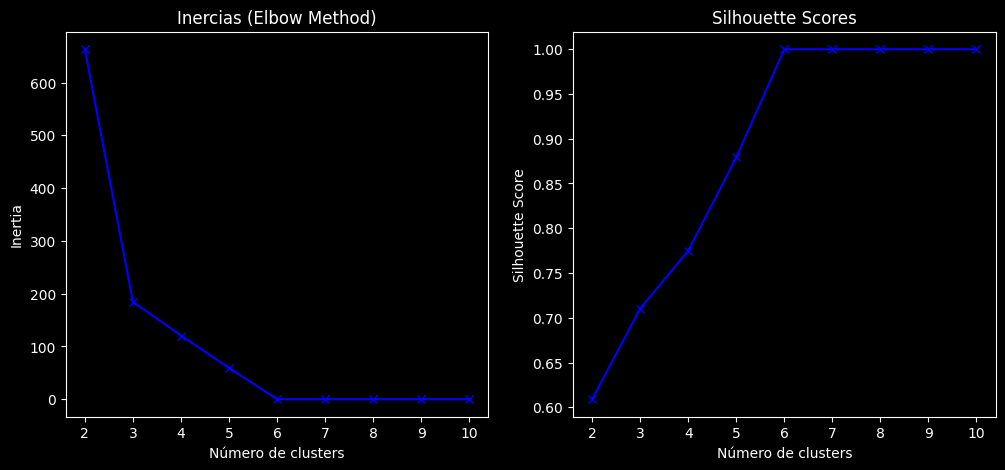

In [58]:
# Clustering de la variable Cantidad para encontrar patrones

k = range(2, 11)
silhouette_scores = []
inertias = []

for n_clusters in k:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(df_scaled[['Cantidad']])
    silhouette = silhouette_score(df_scaled[['Cantidad']], cluster_labels)
    silhouette_scores.append(silhouette)
    inertias.append(kmeans.inertia_)

# Inertias
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(k, inertias, 'bx-')
ax[0].set_xlabel('Número de clusters')
ax[0].set_ylabel('Inertia')
ax[0].set_title('Inercias (Elbow Method)')

ax[1].plot(k, silhouette_scores, 'bx-')
ax[1].set_xlabel('Número de clusters')
ax[1].set_ylabel('Silhouette Score')
ax[1].set_title('Silhouette Scores')
plt.show()

Elegimos 6 clusters debido a que con este número se alcanza un Silhouette Score de 1 y en el gráfico de codo se observa una disminución significativa en la inercia hasta este punto, indicando que agregar más clusters no mejora sustancialmente la cohesión dentro de los clusters.

   ID_Venta  ID_Cliente  ID_Producto  Cantidad  Metodo_Pago_cat  ID_Categoria  \
0 -0.066276    0.117452     0.497474  1.494583        -0.933955      0.391098   
1  0.614024    1.653904     0.236122 -0.854793         1.169657      0.391098   
2  0.198285    0.843584     0.366798 -0.267449        -0.232751      0.391098   
3  0.283037    0.538398     0.236122 -0.267449         1.169657      0.391098   
4  1.369913    0.990915     0.497474 -0.267449        -1.635159      0.391098   

   Precio_Unitario  ID_Metodo  ID_Ticket  Monto_Venta  ...  \
0         0.971069  -0.933955   0.127550     2.106317  ...   
1        -0.475000   1.169657   1.643780    -0.763856  ...   
2         0.404037  -0.232751   0.842444     0.040823  ...   
3        -0.475000   1.169657   0.541067    -0.450168  ...   
4         0.971069  -1.635159   0.994301     0.357542  ...   

   cantidad_/_ventas_region_rmean_30  cantidad_/_ventas_categoria_rstd_30  \
0                                NaN                           

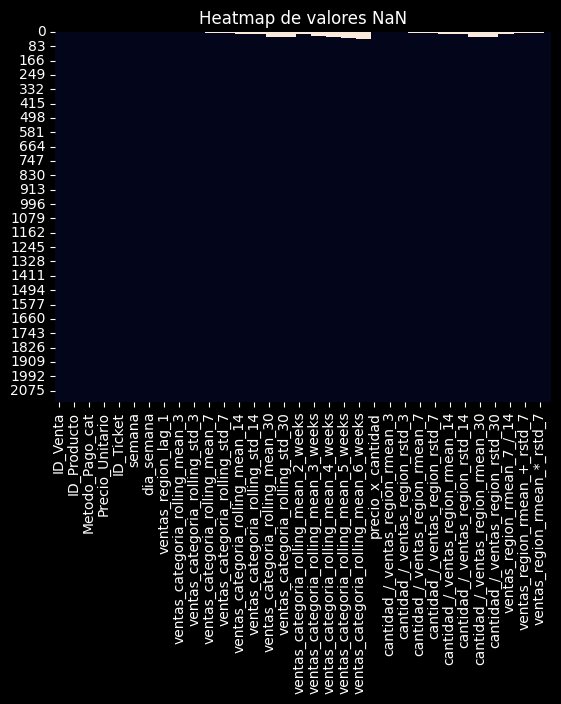

In [59]:
# Forward/backward fill de NaNs para KMeans
df_filled = df_scaled.ffill()

# Heatmap de nans
print(df_filled.head())
plt.figure()
sns.heatmap(df_filled.isna(), cbar=False)
plt.title('Heatmap de valores NaN')
plt.show()

df_filled = df_filled.bfill()

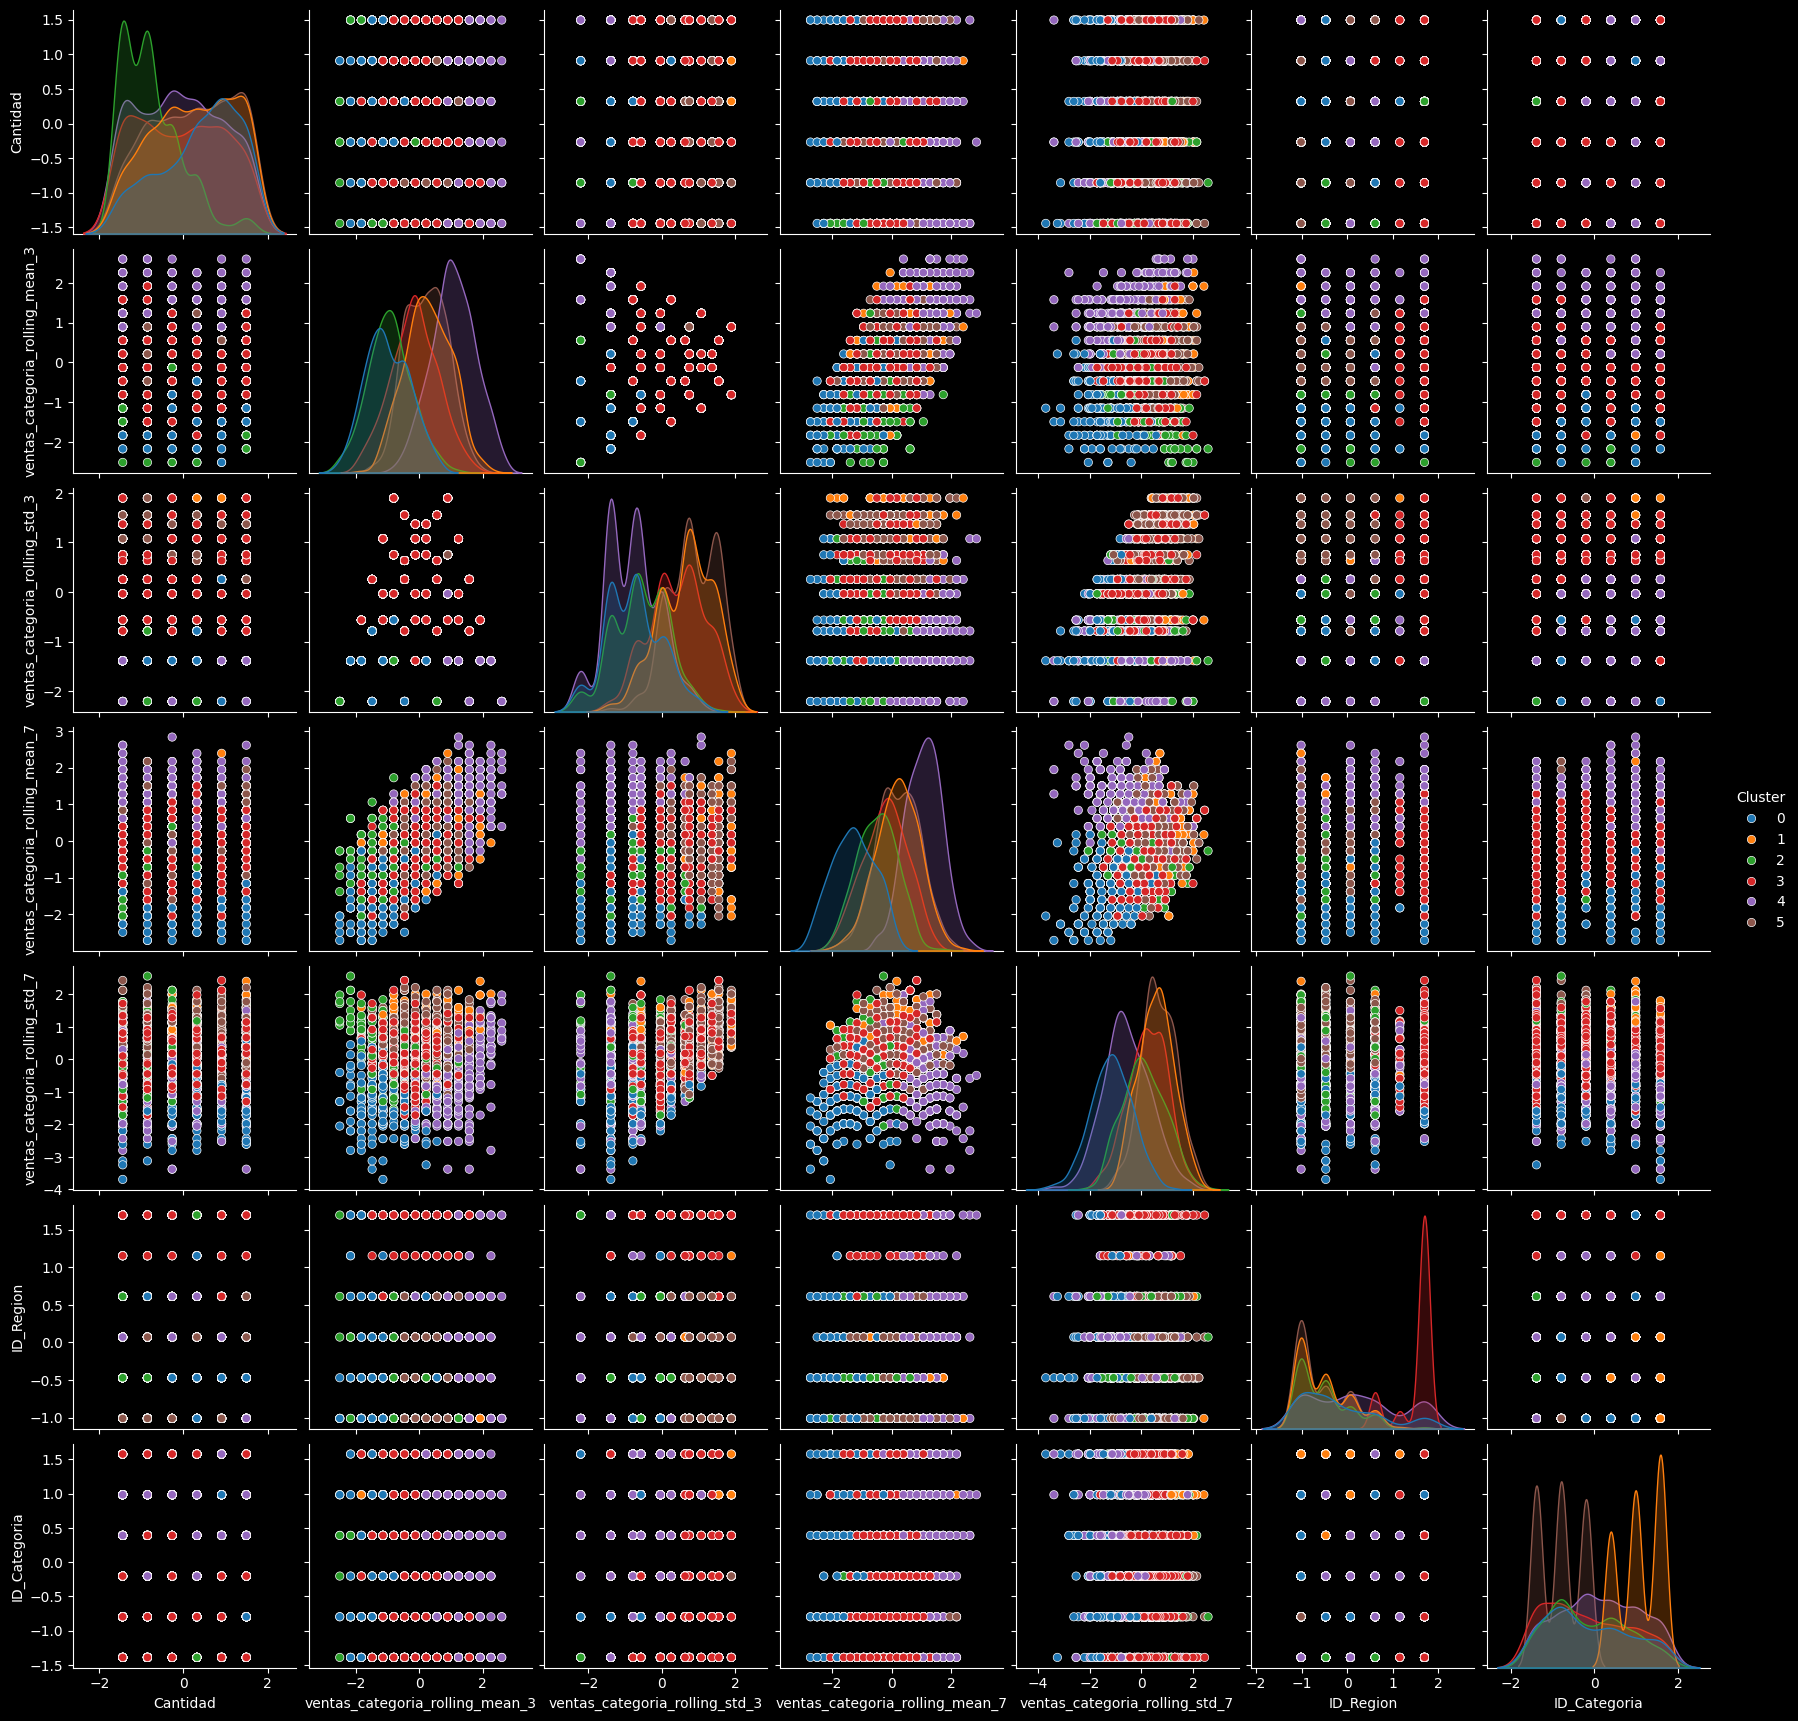

In [60]:
# Pairplot de clusters
optimal_clusters = 6
vars = ['Cantidad', 'ventas_categoria_rolling_mean_3', 'ventas_categoria_rolling_std_3',
        'ventas_categoria_rolling_mean_7', 'ventas_categoria_rolling_std_7','ID_Region', 'ID_Categoria']

kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
df_filled['Cluster'] = kmeans.fit_predict(df_filled[vars])
sns.pairplot(df_filled, hue='Cluster', vars=vars, palette='tab10')
plt.show()

0.7385235092320478


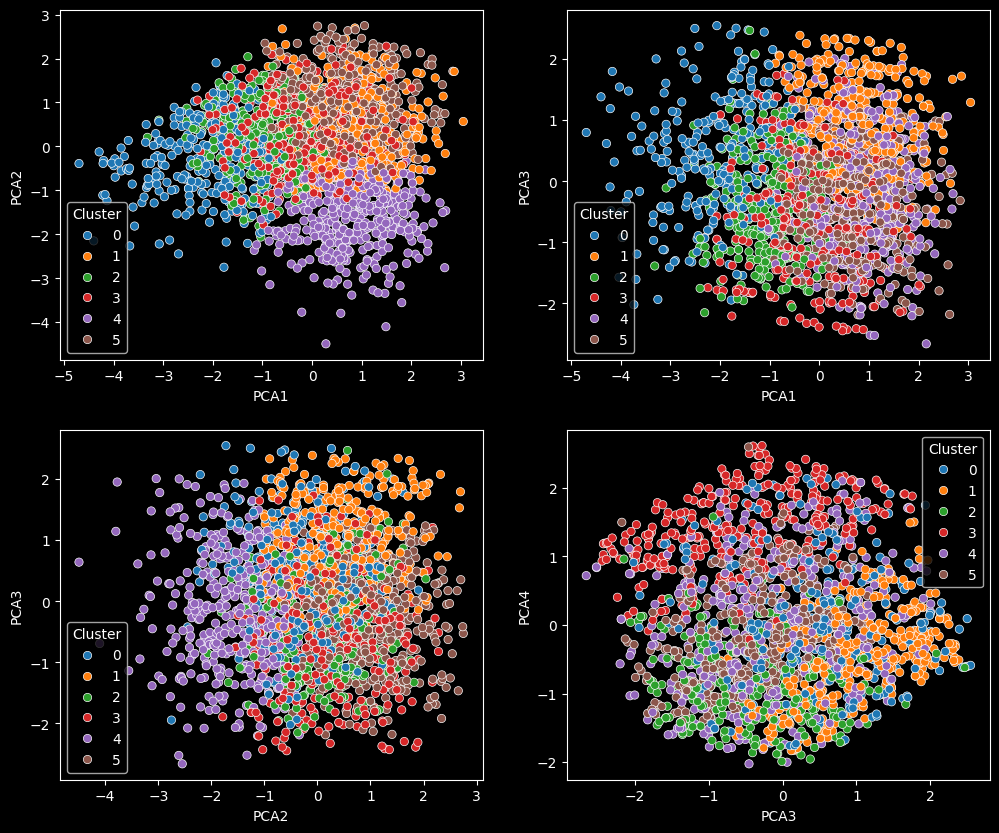

In [61]:
# Visualización de clusters en 2D con PCA
pca = PCA(n_components=4)
df_pca = pca.fit_transform(df_filled[vars])
df_pca = pd.DataFrame(df_pca, columns=['PCA1', 'PCA2', 'PCA3', 'PCA4'])
df_pca['Cluster'] = df_filled['Cluster']
print(pca.explained_variance_ratio_.cumsum()[-1])

fig, ax = plt.subplots(2, 2, figsize=(12, 10))
sns.scatterplot(data=df_pca, x='PCA1', y='PCA2', hue='Cluster', palette='tab10', ax=ax[0, 0])
sns.scatterplot(data=df_pca, x='PCA1', y='PCA3', hue='Cluster', palette='tab10', ax=ax[0, 1])
sns.scatterplot(data=df_pca, x='PCA2', y='PCA3', hue='Cluster', palette='tab10', ax=ax[1, 0])
sns.scatterplot(data=df_pca, x='PCA3', y='PCA4', hue='Cluster', palette='tab10', ax=ax[1, 1])
plt.show()

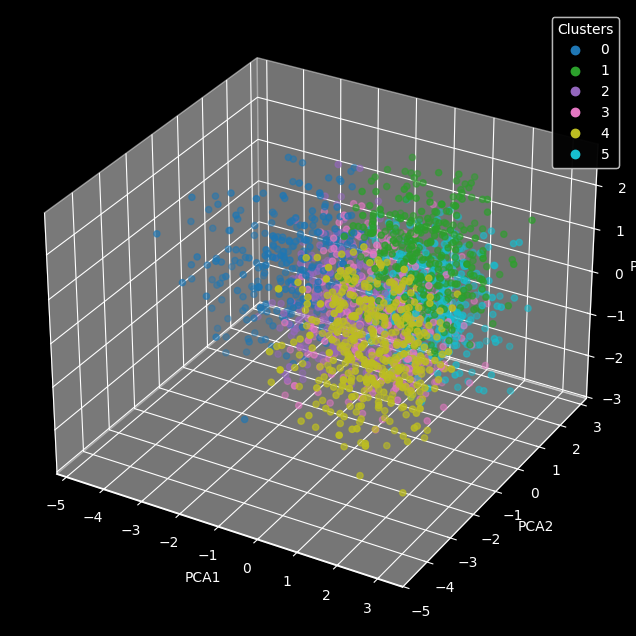

In [62]:
# 3D plot for 3 PCs
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(df_pca['PCA1'], df_pca['PCA2'], df_pca['PCA3'], c=df_pca['Cluster'], cmap='tab10')
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
plt.show()

In [64]:
# Agregamos la columna de cluster al dataframe original
df['Cluster'] = df_filled['Cluster']
df.to_csv('../data_clean/data_fe_clusters.csv', index=False)